In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900


In [3]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [2.93888937]

R-squared:
0.8972106381789521


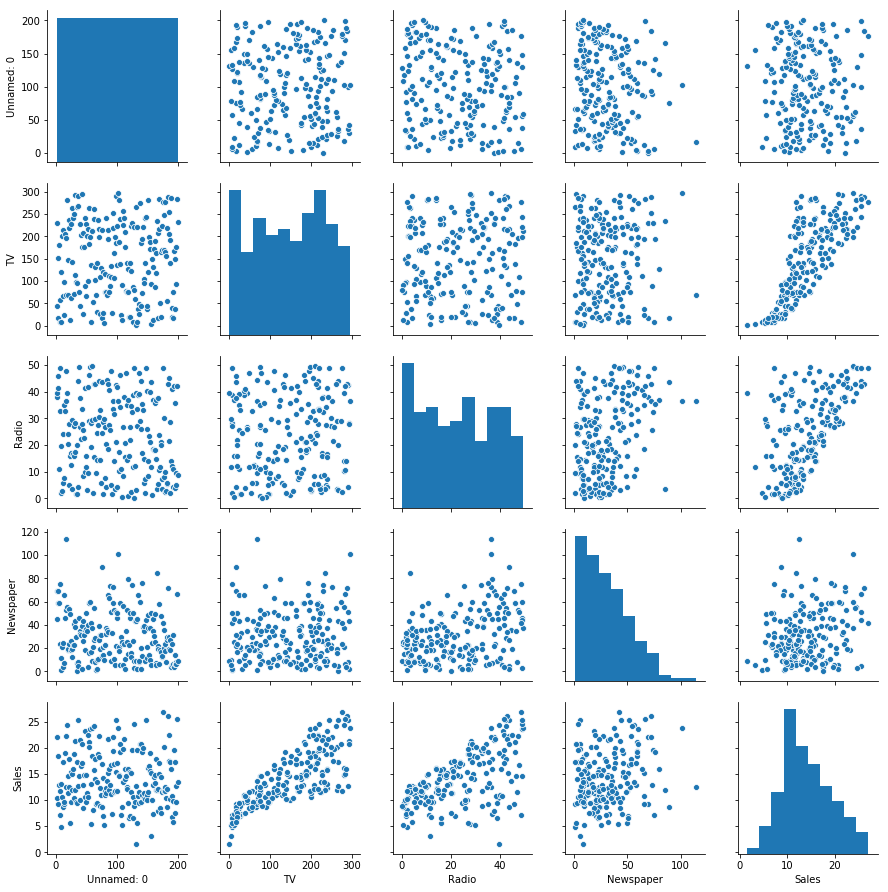

In [5]:
sns.pairplot(data)

From the above plot, we can clearly see that a nonlinear relationship exists between Sales and TV, so let's see if a log transform fixes this.

In [17]:
data['Sales_log'] = np.log(data['Sales']+1)
data['TV_log'] = np.log(data['TV']+1)
data['Radio_log'] = np.log(data.Radio + 1)
data['Newspaper_log'] = np.log(data.Newspaper + 1)

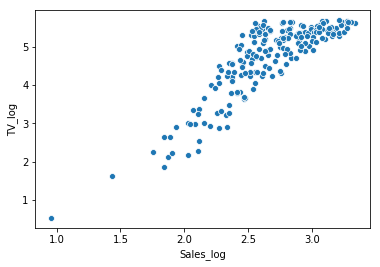

In [5]:
sns.scatterplot(data.Sales_log, data.TV_log)

*This looks more linear :)*

In [7]:
# new model for log transform experiment
regr1 = linear_model.LinearRegression()

Y1 = data['Sales_log'].values.reshape(-1, 1)
X1 = data[['TV_log','Radio','Newspaper']]
regr1.fit(X1, Y1)

# Inspect the results.
print('\nCoefficients: \n', regr1.coef_)
print('\nIntercept: \n', regr1.intercept_)
print('\nR-squared:')
print(regr1.score(X1, Y1))


Coefficients: 
 [[3.32977990e-01 1.23976511e-02 1.28718198e-04]]

Intercept: 
 [0.78972687]

R-squared:
0.9692559387091811


Whoa the R^2 value increased a lot! Notice that the intercept was drastically reduced, this makes a lot more sense as the intercept indicates the number of sales when TV, Radio and Newspaper ads are all zero.

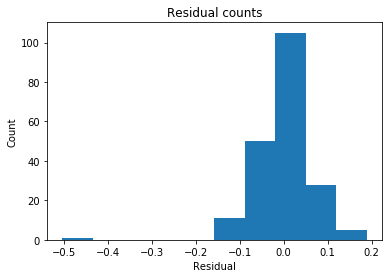

In [8]:
# Extract predicted values.
predicted = regr1.predict(X1).ravel()
actual = data['Sales_log']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

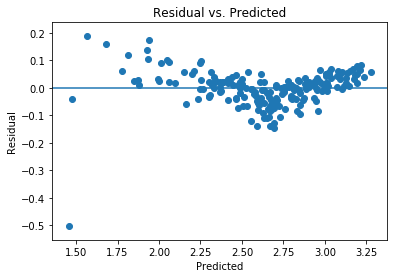

In [9]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

*Interactions between the dependent variables might fix this.*

In [10]:
# make product interactions
data['TV_Radio'] = data['TV_log']*data['Radio']
data['TV_News'] = data['TV_log']*data['Newspaper']
data['Radio_News'] = data['Radio']*data['Newspaper']
data['TV_Radio_News'] = data['TV_log']*data['Radio']*data['Newspaper']

In [12]:
regr2 = linear_model.LinearRegression()

Y2 = data['Sales_log'].values.reshape(-1, 1)
X2 = data[['TV_log','Radio','Newspaper','TV_Radio','TV_News','Radio_News','TV_Radio_News']]
regr2.fit(X2, Y2)

# Inspect the results.
print('\nCoefficients: \n', regr2.coef_)
print('\nIntercept: \n', regr2.intercept_)
print('\nR-squared:')
print(regr2.score(X2, Y2))


Coefficients: 
 [[ 2.41088112e-01 -8.04161048e-03  6.37971154e-04  4.34213939e-03
  -9.63979075e-05  9.60050237e-05 -2.03771103e-05]]

Intercept: 
 [1.22084391]

R-squared:
0.9872771920083285


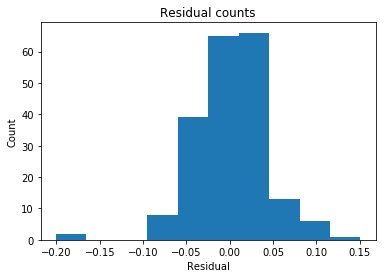

In [13]:
# Extract predicted values.
predicted2 = regr2.predict(X2).ravel()
actual2 = data['Sales_log']

# Calculate the error, also called the residual.
residual2 = actual2 - predicted2

# This looks a bit concerning.
plt.hist(residual2)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

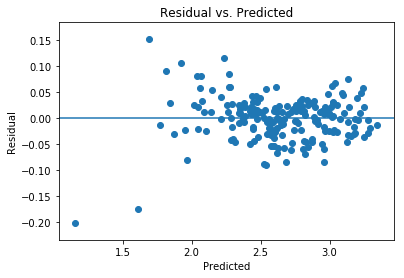

In [14]:
plt.scatter(predicted2, residual2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

*So this did not fix the issue of the 2 outliers, in fact it actually made one more extreme.*

What it looks like to me is that this model is less accurate when predicting lower sales.

In [18]:
data.describe()

,Unnamed: 0,TV,Radio,Newspaper,Sales,Sales_log,TV_log,TV_Radio,TV_News,Radio_News,TV_Radio_News,Radio_log,Newspaper_log
count,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000
mean,100.500,147.042,23.264,30.554,14.023,2.645,4.693,109.093,144.160,824.733,3873.082,2.890,3.153
std,57.879,85.854,14.847,21.779,5.217,0.375,0.962,75.152,109.052,937.820,4501.601,0.906,0.867
min,1.000,0.700,0.000,0.300,1.600,0.956,0.531,0.000,1.676,0.000,0.000,0.000,0.262
25%,50.750,74.375,9.975,12.750,10.375,2.431,4.322,44.444,59.147,147.938,677.794,2.396,2.621
50%,100.500,149.750,22.900,25.750,12.900,2.632,5.016,97.479,121.282,416.115,1927.755,3.174,3.287
75%,150.250,218.825,36.525,45.100,17.400,2.912,5.393,163.389,204.773,1243.190,6460.127,3.625,3.831
max,200.000,296.400,49.600,114.000,27.000,3.332,5.695,275.173,574.633,4172.400,20859.191,3.924,4.745


In [46]:
data.corr()

,Unnamed: 0,TV,Radio,Newspaper,Sales,Sales_log,TV_log,TV_Radio,TV_News,Radio_News,TV_Radio_News,Radio_log,Newspaper_log,TV_log_low,Radio_log_low,Newspaper_log_low,Newspaper_log_high
Unnamed: 0,1.000,0.018,-0.111,-0.155,-0.052,-0.057,0.007,-0.100,-0.115,-0.181,-0.145,-0.112,-0.123,-0.043,0.122,0.075,0.075
TV,0.018,1.000,0.055,0.057,0.782,0.792,0.902,0.342,0.302,0.046,0.223,0.074,0.031,-0.876,-0.047,0.037,0.037
Radio,-0.111,0.055,1.000,0.354,0.576,0.488,-0.006,0.924,0.322,0.708,0.687,0.924,0.252,-0.094,-0.876,-0.031,-0.031
Newspaper,-0.155,0.057,0.354,1.000,0.228,0.213,0.037,0.331,0.943,0.846,0.816,0.302,0.897,-0.061,-0.298,-0.478,-0.478
Sales,-0.052,0.782,0.576,0.228,1.000,0.966,0.758,0.825,0.428,0.416,0.583,0.536,0.165,-0.677,-0.496,0.021,0.021
Sales_log,-0.057,0.792,0.488,0.213,0.966,1.000,0.852,0.759,0.417,0.360,0.521,0.475,0.168,-0.661,-0.417,-0.003,-0.003
TV_log,0.007,0.902,-0.006,0.037,0.758,0.852,1.000,0.327,0.294,0.003,0.192,0.019,0.050,-0.726,0.023,-0.003,-0.003
TV_Radio,-0.100,0.342,0.924,0.331,0.825,0.759,0.327,1.000,0.402,0.653,0.723,0.854,0.241,-0.318,-0.804,-0.008,-0.008
TV_News,-0.115,0.302,0.322,0.943,0.428,0.417,0.294,0.402,1.000,0.776,0.839,0.280,0.849,-0.258,-0.275,-0.449,-0.449
Radio_News,-0.181,0.046,0.708,0.846,0.416,0.360,0.003,0.653,0.776,1.000,0.956,0.610,0.697,-0.055,-0.605,-0.310,-0.310


/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


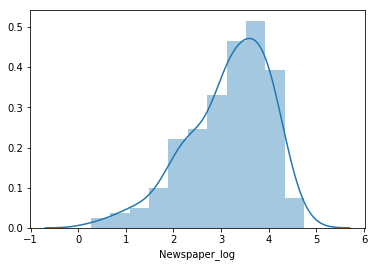

In [42]:
sns.distplot(data.Newspaper_log)

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


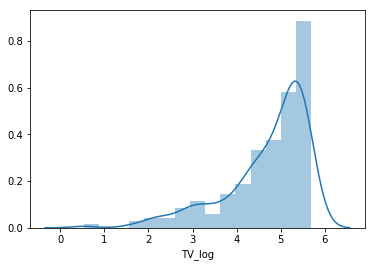

In [47]:
sns.distplot(data.TV_log)

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


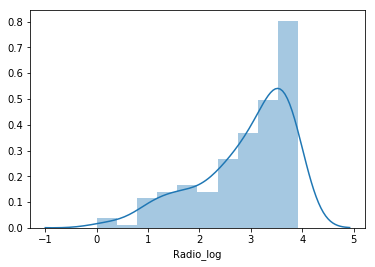

In [48]:
sns.distplot(data.Radio_log)

Let's create some dummy/indicator variables according to the quantiles of the features.

1. Low TV (< 5.393), High TV (> 5.393)
2. Low Radio (< 3.625), High Radio (> 3.625)
3. Low Newspaper (< 3.831), High Newspaper (> 3.831)

*These all correspond to the log-transform of these features.*

In [69]:
data['TV_log_low'] = np.where(data.TV_log < 1.75,1,0)
data['Newspaper_log_low'] = np.where(data['Newspaper_log'] < 1.9,1,0)
data["Radio_log_low"] = np.where(data.Radio_log < 2, 1, 0)

In [71]:
regr3 = linear_model.LinearRegression()

Y3 = data['Sales_log'].values.reshape(-1, 1)
X3 = data[['TV_log','Radio_log','Newspaper_log','TV_Radio','TV_News','Radio_News','TV_Radio_News',
          "TV_log_low", "Newspaper_log_low", "Radio_log_low"]]


regr3.fit(X3, Y3)

# Inspect the results.
print('\nCoefficients: \n', regr3.coef_)
print('\nIntercept: \n', regr3.intercept_)
print('\nR-squared:')
print(regr3.score(X3, Y3))


Coefficients: 
 [[ 2.53392847e-01 -1.06777546e-02  4.55830403e-03  2.60076991e-03
  -2.52607757e-05  1.85129161e-06  1.00739140e-06 -3.01346032e-01
   2.85796218e-02 -4.00436912e-02]]

Intercept: 
 [1.19453181]

R-squared:
0.9907790502184226


*The threshold values used to distinguish between high and low in the TV and Newspaper features has a drastic impact on the model performance.*

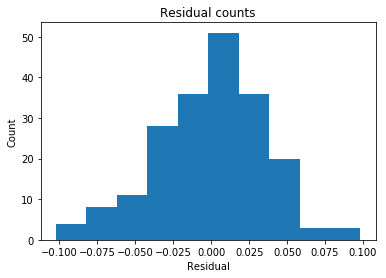

In [72]:
# Extract predicted values.
predicted3 = regr3.predict(X3).ravel()
actual3 = data['Sales_log']

# Calculate the error, also called the residual.
residual3 = actual3 - predicted3

# This looks a bit concerning.
plt.hist(residual3)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

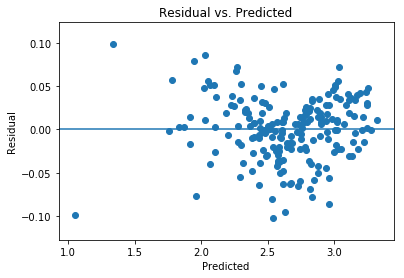

In [73]:
plt.scatter(predicted3, residual3)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

So this model looks to significantly decrease the size of the residuals, however what to do with the outlier (low prediction)?